In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import utilitis_FEEC.Bspline as bspline
import utilitis_FEEC.bsplines as bsp
import utilitis_FEEC.derivatives as der
import utilitis_FEEC.spline_mappings_2d as splmap
import utilitis_FEEC.evaluation as eva

In [85]:
# ... define boundary conditions in each direction (True: periodic, False: else)
bc = [False, True]
bc_1, bc_2 = bc


# ... number of elements and element boundaries in each direction
Nel_1 = 4
Nel_2 = 6

el_b_1 = np.linspace(0., 1., Nel_1 + 1)
el_b_2 = np.linspace(0., 1., Nel_2 + 1)

d1 = 1./Nel_1
d2 = 1./Nel_2

# ... degree of spline basis (of the 0-forms) in each direction
p = [3, 2]
p1, p2 = p


# ... number of basis functions
Nbase = [Nel_1 + p1, Nel_2 + p2] 
Nbase_1, Nbase_2 = Nbase


# ... knot vectors
T1 = bsp.make_knots(el_b_1, p1, bc_1)
T2 = bsp.make_knots(el_b_2, p2, bc_2)  

T2_higher      = np.repeat(bsp.make_knots(el_b_2, 2*p2, bc_2), p2 + 1)
Nbase_2_higher = len(T2_higher)  - 2*p2 - 1 

T = [T1, T2]


# ... greville points
greville_1 = bsp.greville(T1, p1, bc_1)
greville_2 = bsp.greville(T2, p2, bc_2)


# discrete gradient matrices
grad_1 = der.GRAD_1d(p1, Nbase_1, None)
grad_2 = der.GRAD_1d(p2, Nbase_2, True)

In [87]:
# ... create spline mapping
spline_map = splmap.discrete_mapping_2d(p, T, bc)

# ... get controlpoints
cx, cy = spline_map.get_controlpoints()

# ... get barycentric coordinates 
tau, lambdas = spline_map.barycentric_coordinates([cx, cy])

# ... compute coefficients
gl = [lambdas[0](cx[1], cy[1]), lambdas[1](cx[1], cy[1]), lambdas[2](cx[1], cy[1])] 

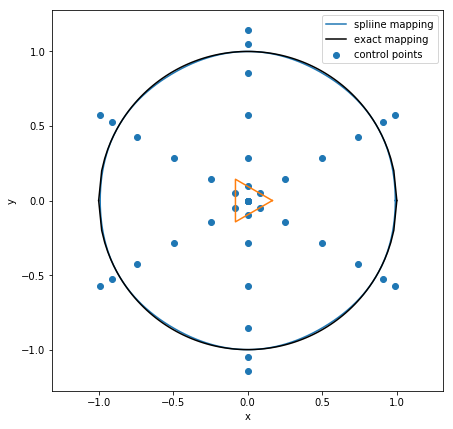

In [88]:
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)


q1plot = np.linspace(0., 1., 100)
q2plot = np.linspace(0., 1., 500)


result_x = spline_map.mapping([cx, cy], [np.array([q1plot[-1]]), q2plot], component='x')
result_y = spline_map.mapping([cx, cy], [np.array([q1plot[-1]]), q2plot], component='y')


plt.plot(result_x, result_y, label='spliine mapping')
plt.axis('equal')


xplot = np.linspace(-1., 1., 100)

plt.plot(xplot,  np.sqrt(1 - xplot**2), 'k', label='exact mapping')
plt.plot(xplot, -np.sqrt(1 - xplot**2), 'k')

plt.scatter(cx, cy, label='control points')

# coordinates of triangle
Tx = np.array([tau, -tau/2, -tau/2, tau])
Ty = np.array([0., np.sqrt(3)/2*tau, -np.sqrt(3)/2*tau, 0.])

plt.plot(Tx, Ty)

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')

In [90]:
# ... tensor basis in H1

#test = np.array([0.] + list(T1))
test = np.insert(T1, 4, T1[4])

N1 = bspline.Bspline(T1, p1)
N2 = bspline.Bspline(T2, p2)

D1 = bspline.Bspline(T1[1:-1], p1 - 1)
D2 = bspline.Bspline(T2[1:-1], p2 - 1)

N2_higher = bspline.Bspline(T2_higher, 2*p2)


# ... three new basis functions Chi^0_l in V0 (l=0,1,2)
def Chi0(l, q1, q2, der_r=0, der_theta=0):
    
    res = np.zeros(q1.shape)
    
    for i2 in range(Nbase_2):
        res += gl[l][i2%Nel_2]*N1(q1, 1, der_r)*N2(q2, i2, der_theta)
        
    res += 1/3*N1(q1, 0, der_r)*(1 - der_theta)
    
    return res



# ... three new basis functions Chi^1_{1,l} in V1 (l=0,1,2) (first component)
def Chi1_1(l, q1, q2, der_theta=0):
    
    res = np.zeros(q1.shape)
    
    for i2 in range(Nbase_2):
        res += gl[l][i2%Nel_2]*p1*D1(q1, 0)*N2(q2, i2, der_theta)
        
    res += -1/3*p1*D1(q1, 0)
    
    return res



# ... three new basis functions Chi^1_{2,l} in V1 (l=0,1,2) (second component)
def Chi1_2(l, q1, q2, der_r=0):
    
    res = np.zeros(q1.shape)
    
    coeff = np.dot(grad_2, gl[l])
    
    for i2 in range(Nbase_2 - 1):
        res += coeff[i2%Nel_2]*N1(q1, 1, der_r)*D2(q2, i2)/d2
    
    return res





# ... three new basis functions Chi^2_l in V2 (l=0,1,2)
def Chi2(l, q1, q2):
    
    res = np.zeros(q1.shape)
    
    coeff = np.dot(grad_2, gl[l])
    
    for i2 in range(Nbase_2 - 1):
        res += coeff[i2%Nel_2]*p1*D1(q1, 0)*D2(q2, i2)/d2
    
    return res



# ... FEM field in V0
def Lambda0(vec_a, vec, q1, q2, der_r=0, der_theta=0):
    
    res = np.zeros(q1.shape)
    
    for i1 in range(Nbase_1 - 2):
        for i2 in range(Nbase_2):
            res += vec[i1, i2%Nel_2]*N1(q1, i1 + 2, der_r)*N2(q2, i2, der_theta)
            
    for l in range(3):
        res += vec_a[l]*Chi0(l, q1, q2, der_r, der_theta)
        
    return res



# ... FEM field in V1 (first component)
def Lambda1_1(vec_a, vec, q1, q2, der_theta=0):
    
    res = np.zeros(q1.shape)
    
    for i1 in range(Nbase_1 - 2):
        for i2 in range(Nbase_2):
            res += vec[i1, i2%Nel_2]*p1*D1(q1, i1 + 1)*N2(q2, i2, der_theta)
            
    for l in range(3):
        res += vec_a[l]*Chi1_1(l, q1, q2, der_theta)
        
    return res


# ... FEM field in V1 (second component)
def Lambda1_2(vec_a, vec, q1, q2, der_r=0):
    
    res = np.zeros(q1.shape)
    
    for i1 in range(Nbase_1 - 2):
        for i2 in range(Nbase_2):
            res += vec[i1, i2%Nel_2]*N1(q1, i1 + 2, der_r)*D2(q2, i2)/d2
            
    for l in range(3):
        res += vec_a[l]*Chi1_2(l, q1, q2, der_r)
        
    return res

In [91]:
# ... discrete derivatives

# gradient
GRAD1 = np.kron(grad_1, np.identity(Nel_2))
GRAD2 = np.kron(np.identity(Nbase_1), grad_2)

C = np.zeros((Nbase_1*Nel_2 - 2*Nel_2, 3))
C[:Nel_2] = -np.array(gl).T

GRAD1 = np.block([[np.identity(3), np.zeros((3, (Nbase_1 - 2)*Nel_2))], [C, GRAD1[Nel_2:, 2*Nel_2:]]])
GRAD2 = np.block([[np.identity(3), np.zeros((3, (Nbase_1 - 2)*Nel_2))], [np.zeros(((Nbase_1 - 2)*Nel_2, 3)), GRAD2[2*Nel_2:, 2*Nel_2:]]])

GRAD = np.block([[GRAD1], [GRAD2]])

# curl
GRAD1 = np.kron(grad_1, np.identity(Nel_2))
GRAD2 = np.kron(np.identity(Nbase_1), grad_2)

gl_diff = np.dot(grad_2, np.array(gl).T)

C = np.zeros((Nbase_1*Nel_2 - 2*Nel_2, 3))
C[:Nel_2] = -gl_diff


CURL1 = np.block([[np.identity(3), np.zeros((3, (Nbase_1 - 2)*Nel_2))], [np.zeros(((Nbase_1 - 2)*Nel_2, 3)), GRAD2[2*Nel_2:, 2*Nel_2:]]])
CURL2 = np.block([[np.identity(3), np.zeros((3, (Nbase_1 - 2)*Nel_2))], [C, GRAD1[Nel_2:, 2*Nel_2:]]])


CURL = np.block([[-CURL1, CURL2]])

# 1. 1d basis functions on logical domain

Text(0.5,1,'$N^{\\prime\\prime}(r)$')

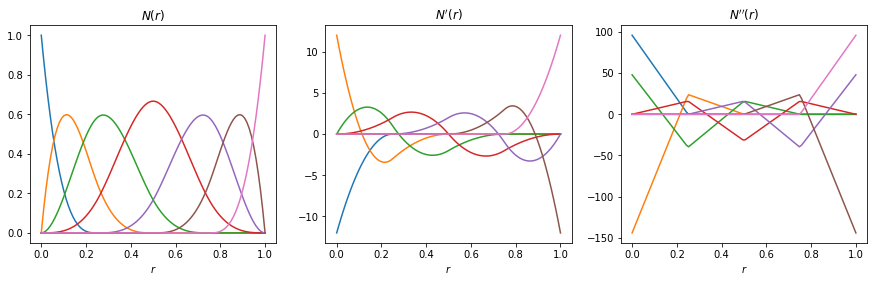

In [92]:
fig = plt.figure()
fig.set_figwidth(15)

plt.subplot(1, 3, 1)

        
        
for i1 in range(Nbase_1):
    plt.plot(q1plot, N1(q1plot, i1, 0))
    
    
plt.xlabel('$r$')
plt.title('$N(r)$')    

    
plt.subplot(1, 3, 2)
    
for i1 in range(Nbase_1):
    plt.plot(q1plot, N1(q1plot, i1, 1))
    
plt.xlabel('$r$')
plt.title('$N^\prime(r)$') 


plt.subplot(1, 3, 3)
    
for i1 in range(Nbase_1):
    plt.plot(q1plot, N1(q1plot, i1, 2))
    
plt.xlabel('$r$')
plt.title('$N^{\prime\prime}(r)$')    

Text(0.5,1,'$D_i(r) - D_{i+1}(r)$')

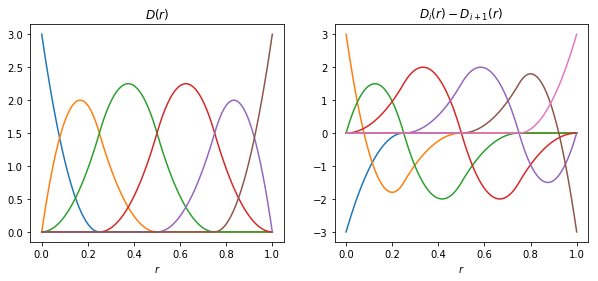

In [93]:
fig = plt.figure()
fig.set_figwidth(10)

plt.subplot(1, 2, 1)

for i1 in range(Nbase_1 - 1):
    plt.plot(q1plot, p1*D1(q1plot, i1))
    
plt.xlabel('$r$')
plt.title('$D(r)$')

plt.subplot(1, 2, 2)

for i1 in range(Nbase_1):
    
    if i1 == 0:
        plt.plot(q1plot, -p1*D1(q1plot, i1))
        
    else:
        plt.plot(q1plot, p1*D1(q1plot, i1 - 1) - p1*D1(q1plot, i1))

plt.xlabel('$r$')
plt.title('$D_i(r) - D_{i+1}(r)$')

Text(0.5,1,'$N^\\prime(\\theta)$')

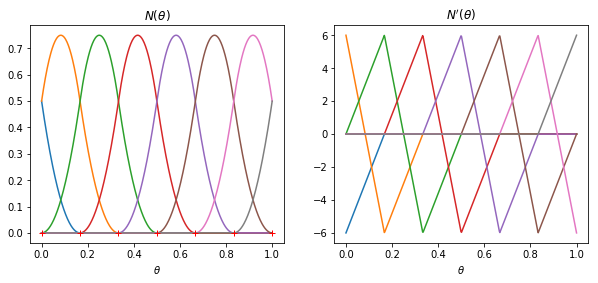

In [102]:
fig = plt.figure()
fig.set_figwidth(10)

plt.subplot(1, 2, 1)

for i2 in range(Nbase_2):
    plt.plot(q2plot, N2(q2plot, i2))
    
plt.xlabel(r'$\theta$')
plt.title(r'$N(\theta)$')

plt.plot(el_b_2, np.zeros(Nel_2 + 1), 'r+')

plt.subplot(1, 2, 2)

for i2 in range(Nbase_2):
    plt.plot(q2plot, N2(q2plot, i2, 1))
    
plt.xlabel(r'$\theta$')
plt.title(r'$N^\prime(\theta)$')

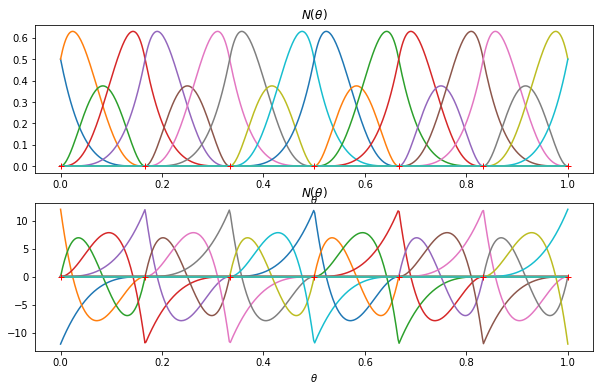

In [106]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.subplot(2, 1, 1)

for i2 in range(Nbase_2_higher):
    plt.plot(q2plot, N2_higher(q2plot, i2))
    
plt.xlabel(r'$\theta$')
plt.title(r'$N(\theta)$')

plt.plot(el_b_2, np.zeros(Nel_2 + 1), 'r+')

plt.subplot(2, 1, 2)

for i2 in range(Nbase_2_higher):
    plt.plot(q2plot, N2_higher(q2plot, i2, 1))
    
plt.xlabel(r'$\theta$')
plt.title(r'$N(\theta)$')

plt.plot(el_b_2, np.zeros(Nel_2 + 1), 'r+')

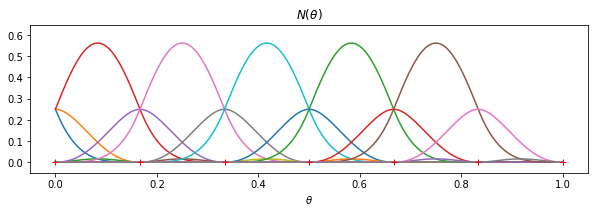

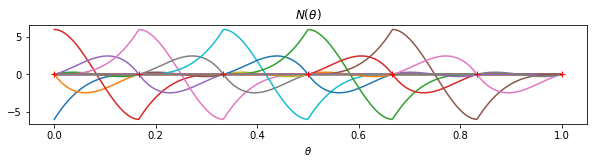

In [111]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.subplot(2, 1, 1)

for j in range(Nbase_2 - p2):
    for k in range(p2 + 1):
        plt.plot(q2plot, N2(q2plot, j)*N2(q2plot, j + k))
    
plt.xlabel(r'$\theta$')
plt.title(r'$N(\theta)$')
plt.ylim((-0.05, 0.65))

plt.plot(el_b_2, np.zeros(Nel_2 + 1), 'r+')


fig = plt.figure()
fig.set_figwidth(10)

plt.subplot(2, 1, 2)

for j in range(Nbase_2 - p2):
    for k in range(p2 + 1):
        plt.plot(q2plot, (N2(q2plot, j, 1)*N2(q2plot, j + k, 0) + N2(q2plot, j, 0)*N2(q2plot, j + k, 1)))
    
plt.xlabel(r'$\theta$')
plt.title(r'$N(\theta)$')

plt.plot(el_b_2, np.zeros(Nel_2 + 1), 'r+')

Text(0.5,1,'$D_{i}(r) - D_{i+1}(r)$')

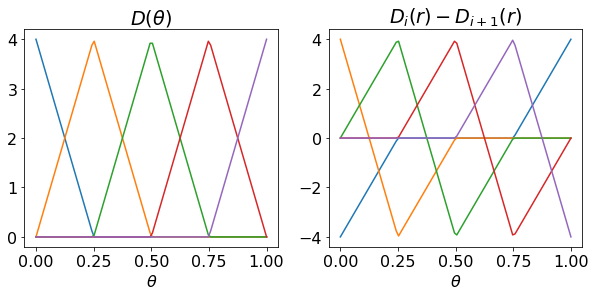

In [211]:
fig = plt.figure()
fig.set_figwidth(10)

plt.subplot(1, 2, 1)

for i2 in range(Nbase_2 - 1):
    plt.plot(q2plot, D2(q2plot, i2)/d2)
    
plt.xlabel(r'$\theta$')
plt.title(r'$D(\theta)$')

plt.subplot(1, 2, 2)
for i2 in range(Nbase_2 - 1):
    plt.plot(q2plot, D2(q2plot, i2 - 1)/d2 - D2(q2plot, i2)/d2)
    
plt.xlabel(r'$\theta$')
plt.title('$D_{i}(r) - D_{i+1}(r)$')

# 2. Basis functions on physical domain

## 2. 1 2d basis functions $\chi^0_{l=0,1,2}$ in $V_0$

In [170]:
Q1plot, Q2plot = np.meshgrid(q1plot, q2plot, indexing='ij')

In [171]:
CHI0_0 = Chi0(0, Q1plot, Q2plot)
CHI0_1 = Chi0(1, Q1plot, Q2plot)
CHI0_2 = Chi0(2, Q1plot, Q2plot)

Text(0.5,0,'$\\chi^0_{l=0}$')

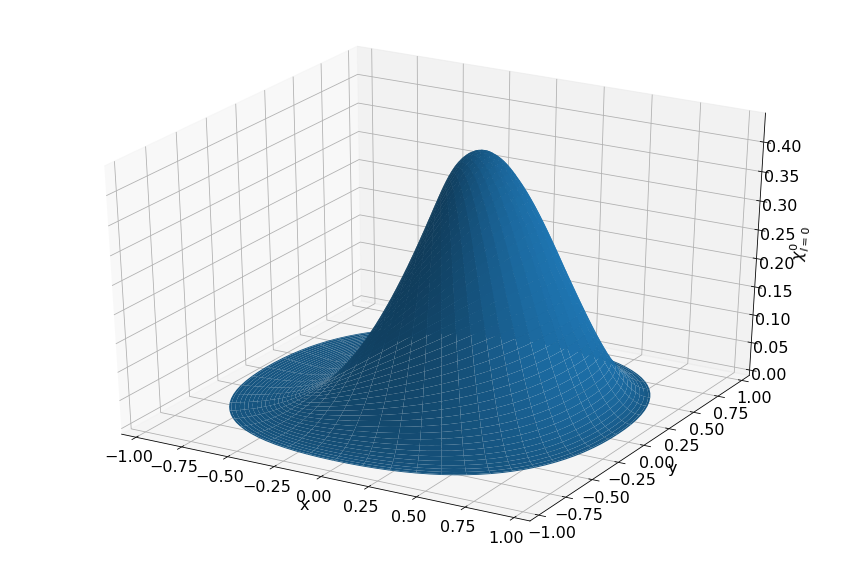

In [172]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI0_0)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^0_{l=0}$')

Text(0.5,0,'$\\chi^0_{l=1}$')

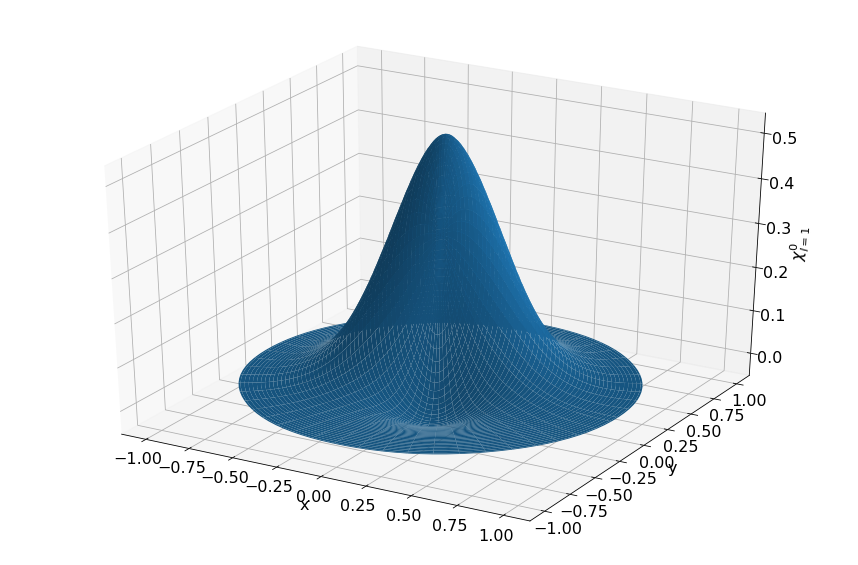

In [150]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI0_1)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^0_{l=1}$')

Text(0.5,0,'$\\chi^0_{l=2}$')

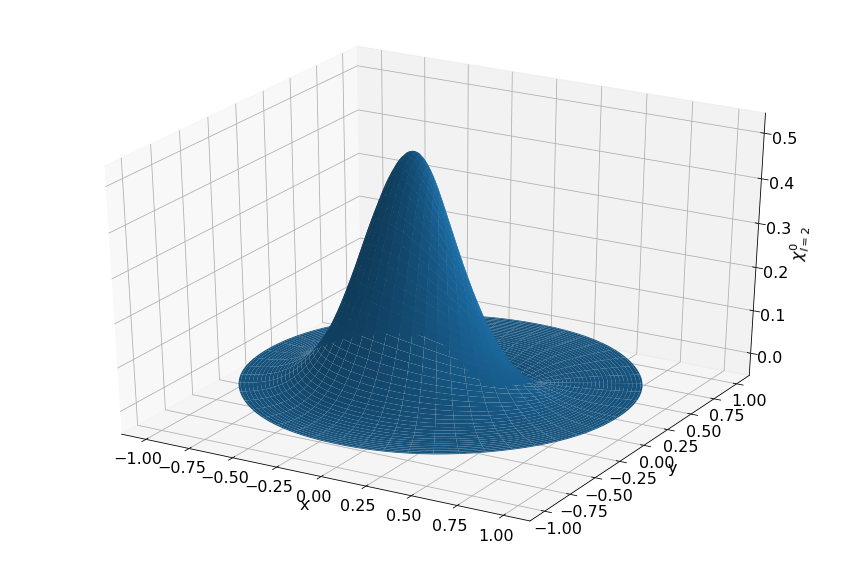

In [151]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI0_2)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^0_{l=2}$')

## 2. 2 2d basis functions $\chi^1_{1,l=0,1,2}$ in $V_1$ (first component)

In [178]:
Q1plot, Q2plot = np.meshgrid(q1plot[1:], q2plot, indexing='ij')

In [179]:
J = spline_map.jacobian_inverse_trans([cx, cy], [q1plot[1:], q2plot])

for i in range(2):
    for j in range(2):
        J[i][j] = np.reshape(J[i][j], (99, 100))

det_JT = J[0][0]*J[1][1] - J[1][0]*J[0][1]

In [180]:
# transformed functions 
CHI1_10 = 1/det_JT*(J[1][1]*Chi1_1(0, Q1plot, Q2plot) - J[1][0]*Chi1_2(0, Q1plot, Q2plot))
CHI1_11 = 1/det_JT*(J[1][1]*Chi1_1(1, Q1plot, Q2plot) - J[1][0]*Chi1_2(1, Q1plot, Q2plot))
CHI1_12 = 1/det_JT*(J[1][1]*Chi1_1(2, Q1plot, Q2plot) - J[1][0]*Chi1_2(2, Q1plot, Q2plot))

Text(0.5,0,'$\\chi^1_{1,l=0}$')

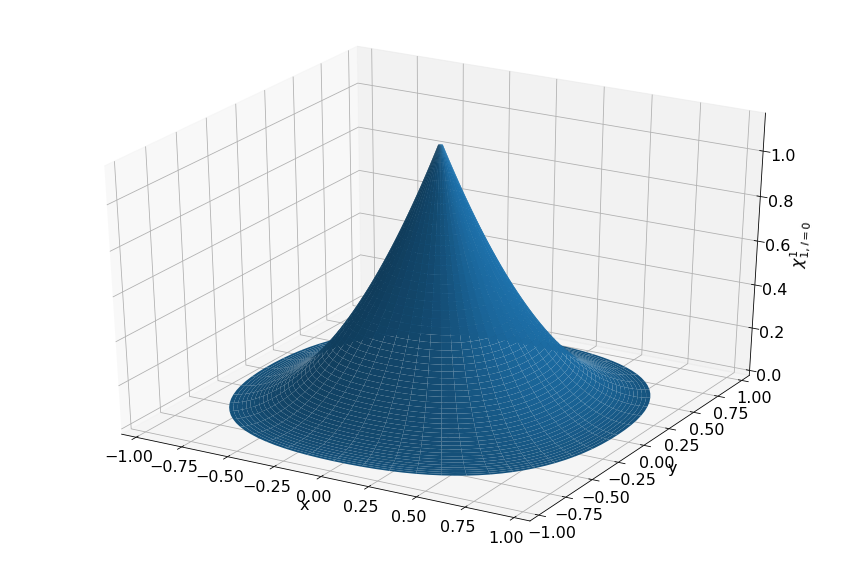

In [181]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI1_10)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^1_{1,l=0}$')

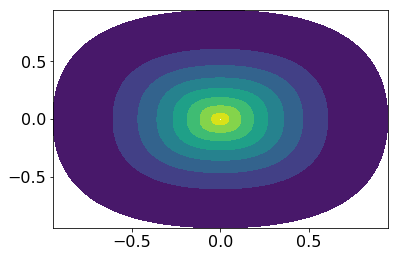

In [182]:
plt.contourf(X, Y, CHI1_10)

Text(0.5,0,'$\\chi^1_{1,l=1}$')

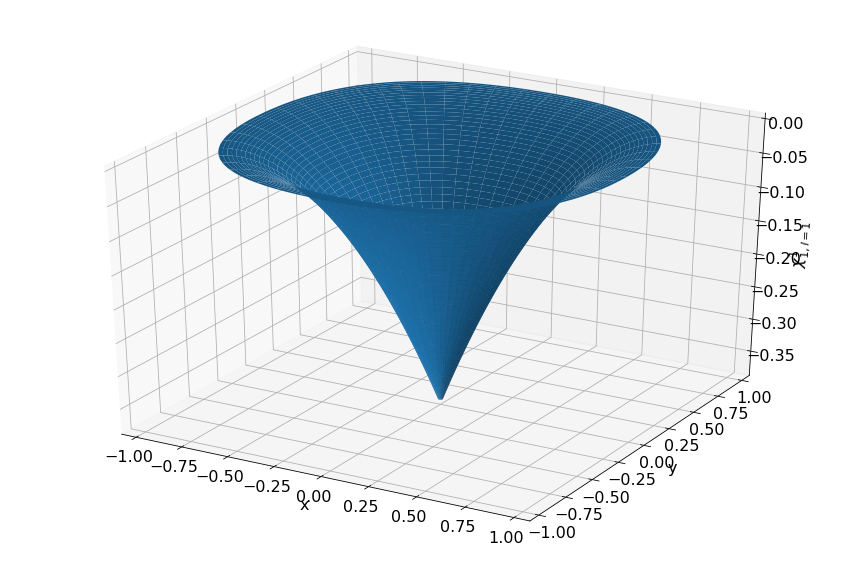

In [31]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI1_11)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^1_{1,l=1}$')

Text(0.5,0,'$\\chi^1_{1,l=2}$')

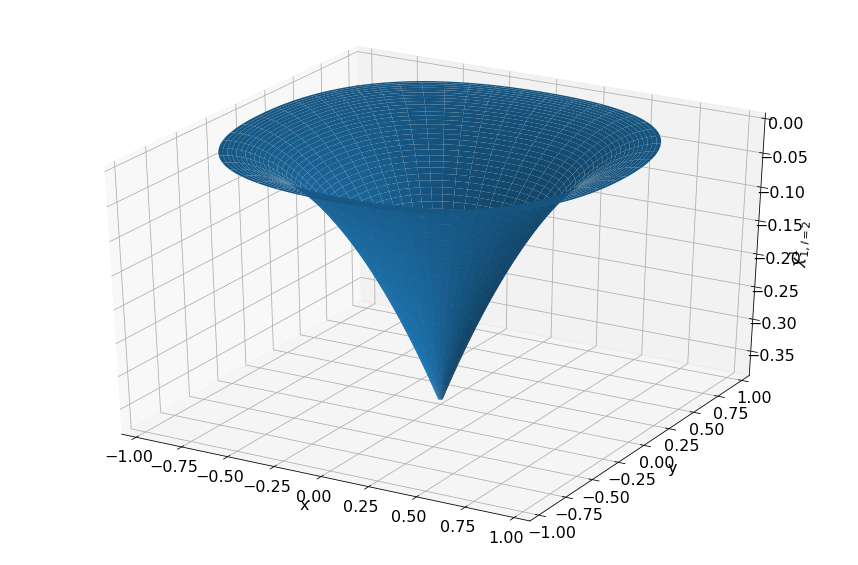

In [32]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI1_12)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^1_{1,l=2}$')

## 2. 2 2d basis functions $\chi^1_{2,l=0,1,2}$ in $V_1$ (second component)

In [33]:
Q1plot, Q2plot = np.meshgrid(q1plot[1:], q2plot, indexing='ij')

In [188]:
J = spline_map.jacobian_inverse_trans([cx, cy], [q1plot[1:], q2plot])

for i in range(2):
    for j in range(2):
        J[i][j] = np.reshape(J[i][j], (99, 100))

det_JT = J[0][0]*J[1][1] - J[1][0]*J[0][1]

In [35]:
# transformed functions 
CHI1_20 = 1/det_JT*(-J[0][1]*Chi1_1(0, Q1plot, Q2plot) + J[0][0]*Chi1_2(0, Q1plot, Q2plot))
CHI1_21 = 1/det_JT*(-J[0][1]*Chi1_1(1, Q1plot, Q2plot) + J[0][0]*Chi1_2(1, Q1plot, Q2plot))
CHI1_22 = 1/det_JT*(-J[0][1]*Chi1_1(2, Q1plot, Q2plot) + J[0][0]*Chi1_2(2, Q1plot, Q2plot))

Text(0.5,0,'$\\chi^1_{2,l=0}$')

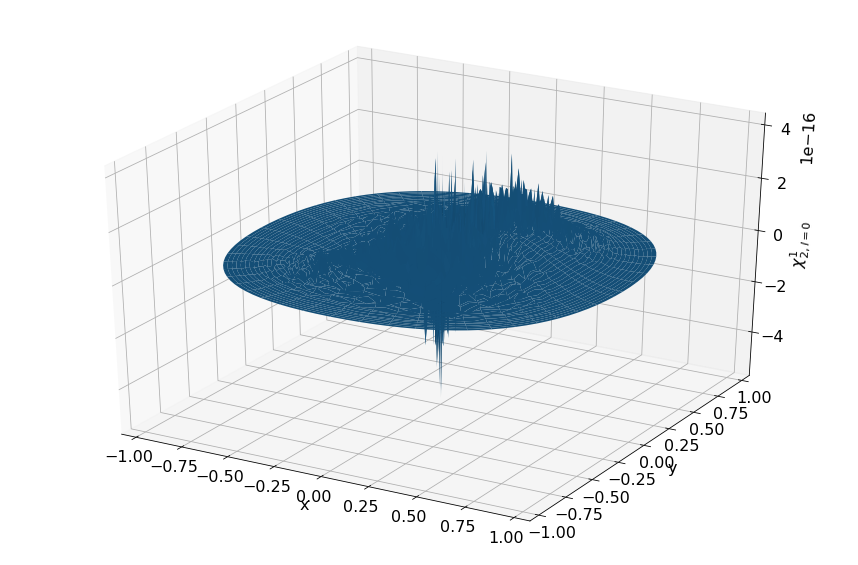

In [36]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI1_20)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^1_{2,l=0}$')

Text(0.5,0,'$\\chi^1_{2,l=1}$')

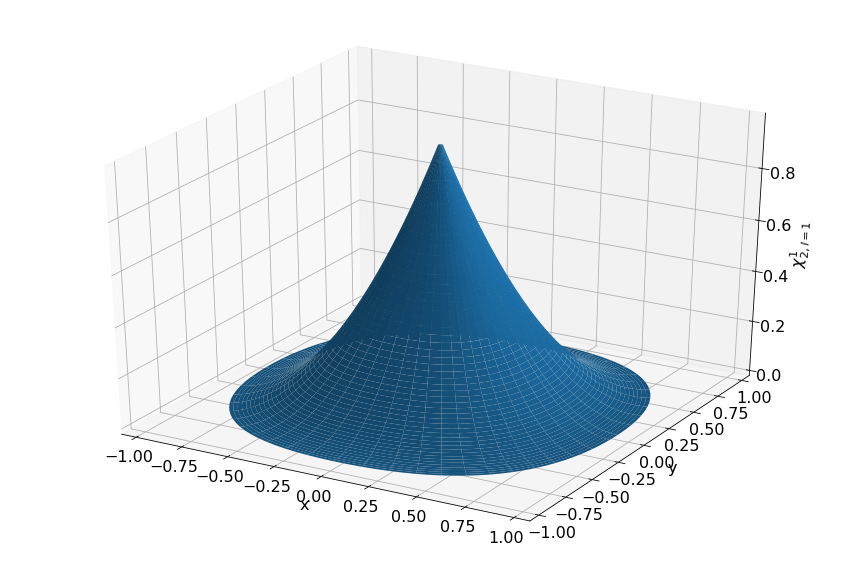

In [37]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI1_21)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^1_{2,l=1}$')

Text(0.5,0,'$\\chi^1_{2,l=2}$')

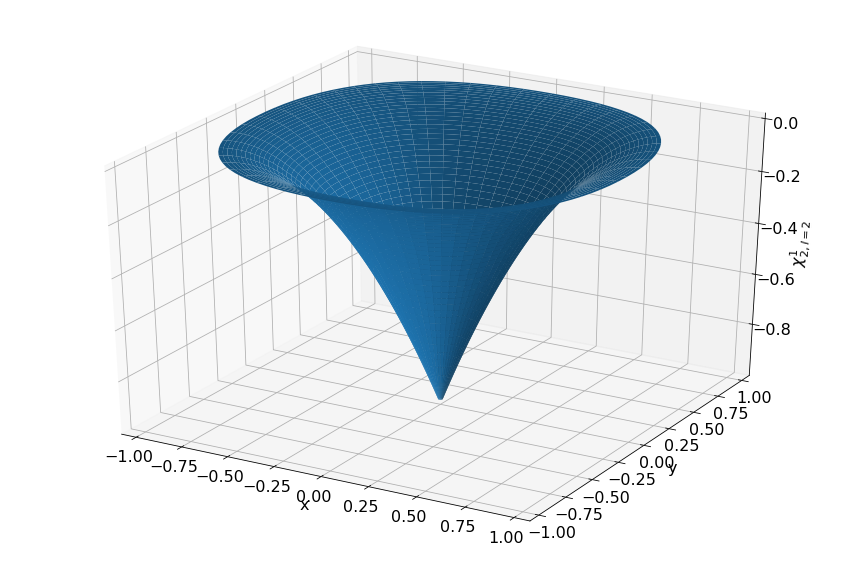

In [38]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI1_22)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^1_{2,l=2}$')

## 2. 2 2d basis functions $\chi^2_{l=0,1,2}$ in $V_2$

In [212]:
Q1plot, Q2plot = np.meshgrid(q1plot, q2plot, indexing='ij')

#Q1plot, Q2plot = np.meshgrid(q1plot[1:], q2plot, indexing='ij')

In [213]:
CHI2_0 = Chi2(0, Q1plot, Q2plot)
CHI2_1 = Chi2(1, Q1plot, Q2plot)
CHI2_2 = Chi2(2, Q1plot, Q2plot)


#CHI2_0 = 1/det_JT*Chi2(0, Q1plot, Q2plot)
#CHI2_1 = det_JT*Chi2(1, Q1plot, Q2plot)
#CHI2_2 = det_JT*Chi2(2, Q1plot, Q2plot)

In [215]:
%matplotlib qt

In [216]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)


X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')


#X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
#Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))

#X = np.reshape(X, (99, 100))
#Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI2_0)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^2_{l=0}$')

Text(0.5,0,'$\\chi^2_{l=0}$')

Text(0.5,0,'$\\chi^2_{l=1}$')

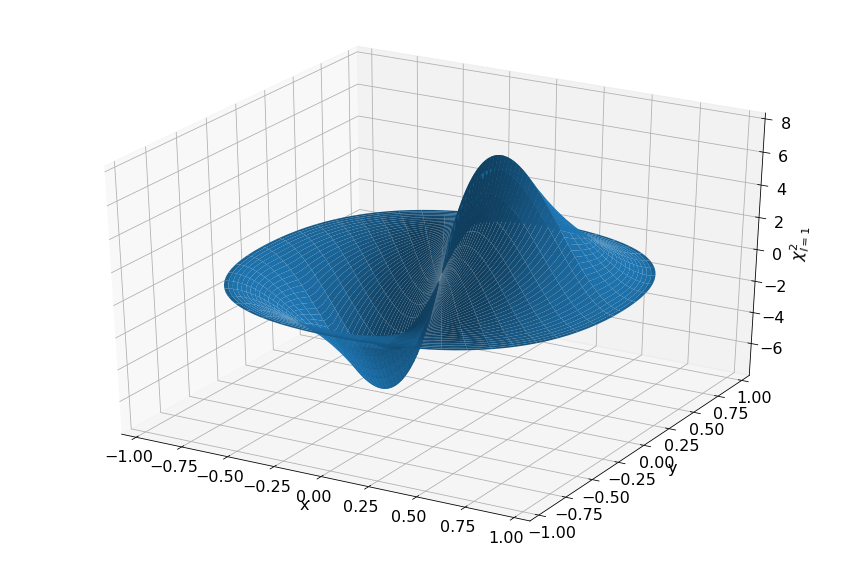

In [53]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)


#X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
#Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')


X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

#X = np.reshape(X, (100, 100))
#Y = np.reshape(Y, (100, 100))

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI2_1)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^2_{l=1}$')

Text(0.5,0,'$\\chi^2_{l=2}$')

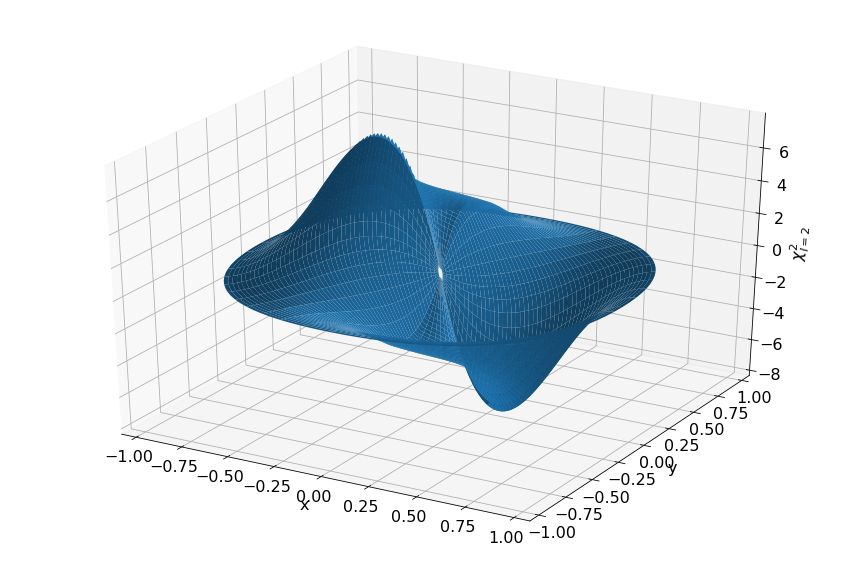

In [54]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)


#X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
#Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')


X = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot[1:], q2plot], component='y')

#X = np.reshape(X, (100, 100))
#Y = np.reshape(Y, (100, 100))

X = np.reshape(X, (99, 100))
Y = np.reshape(Y, (99, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, CHI2_2)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\chi^2_{l=2}$')

## 3. Discrete derivatives

## 3. 1 Going from $V_0$ to $V_1$ with $\mathbb{G}$

In [106]:
vec0 = np.random.rand(3 + Nbase_1*Nel_2 - 2*Nel_2)


# C1 constraint on coefficients of tensor basis
g0 = 1/3*(vec0[0] + vec0[1] + vec0[2])
g1 = vec0[0]*gl[0] + vec0[1]*gl[1] + vec0[2]*gl[2]

vec0_full = np.concatenate((np.array([g0] * Nel_2), g1, vec0[3:]))

Text(0.5,0.92,'$\\phi$')

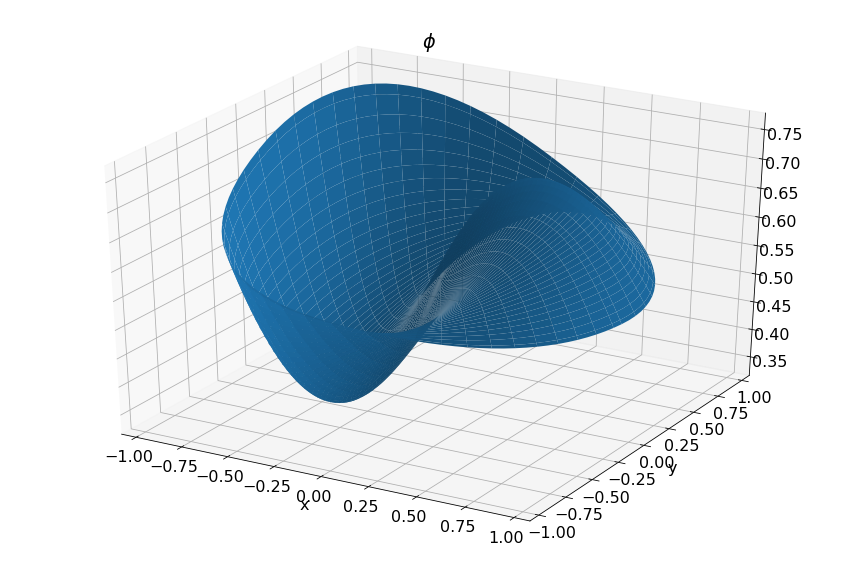

In [107]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


PHI = eva.evaluate_field_V0_2d(vec0_full, [q1plot, q2plot], p, Nbase, T, bc)
PHI = np.reshape(PHI, (100, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, PHI)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(r'$\phi$')

Text(0.5,0.92,'$\\partial_r\\phi$')

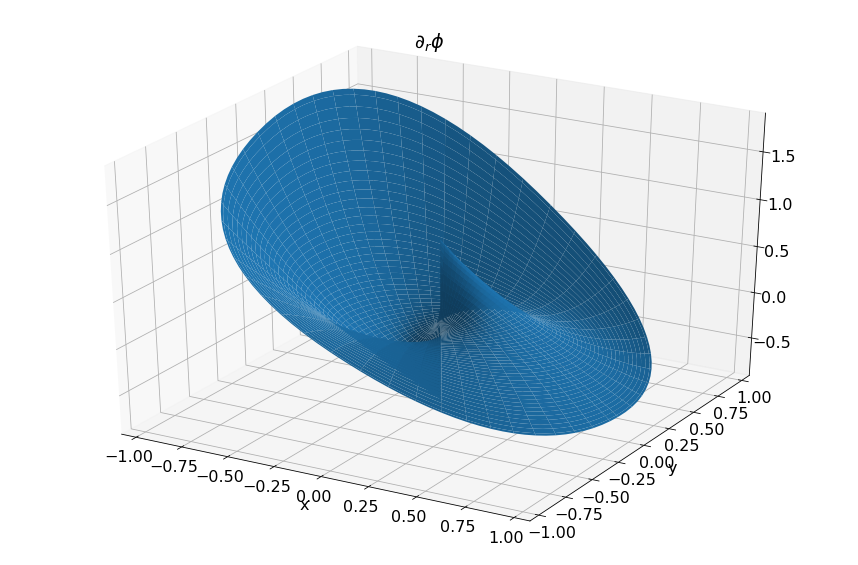

In [108]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


test_vec_a = vec0[:3]
test_vec = np.reshape(vec0[3:], (Nbase_1 - 2, Nel_2))

Q1plot, Q2plot = np.meshgrid(q1plot, q2plot, indexing='ij')

TEST = Lambda0(test_vec_a, test_vec, Q1plot, Q2plot, 1, 0)
TEST = np.reshape(TEST, (100, 100))

ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, TEST)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(r'$\partial_r\phi$')

Text(0.5,0.92,'$\\partial_\\theta\\phi$')

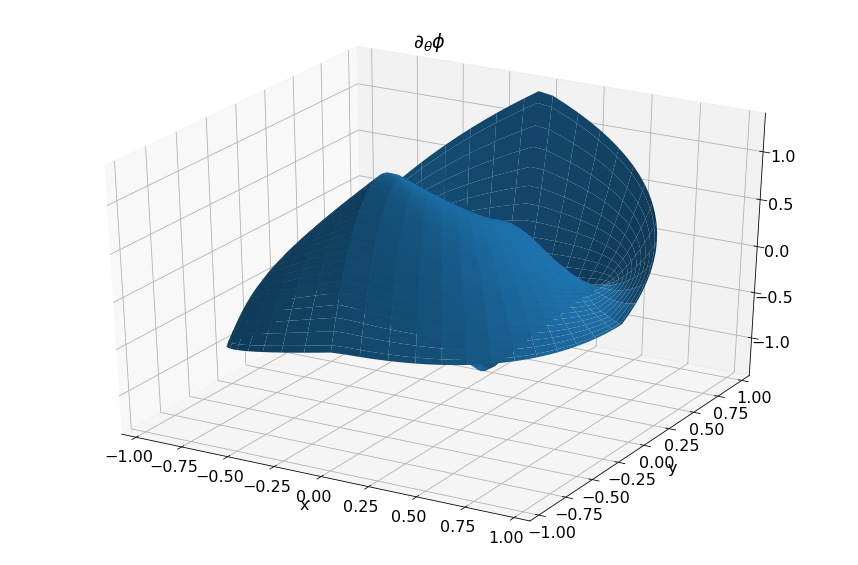

In [109]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


test_vec_a = vec0[:3]
test_vec = np.reshape(vec0[3:], (Nbase_1 - 2, Nel_2))

Q1plot, Q2plot = np.meshgrid(q1plot, q2plot, indexing='ij')

TEST = Lambda0(test_vec_a, test_vec, Q1plot, Q2plot, 0, 1)
TEST = np.reshape(TEST, (100, 100))

ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, TEST)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(r'$\partial_\theta\phi$')

In [110]:
vec1 = GRAD.dot(vec0)

vec1_1, vec1_2 = np.split(vec1, 2)

# C1 constraint on coefficients of tensor basis
g0_1 = vec1_1[0]*(-1/3 + gl[0]) + vec1_1[1]*(-1/3 + gl[1]) + vec1_1[2]*(-1/3 + gl[2])
g0_2 = vec1_2[0]*grad_2.dot(gl[0]) + vec1_2[1]*grad_2.dot(gl[1]) + vec1_2[2]*grad_2.dot(gl[2])

vec1_1_full = np.concatenate((g0_1, vec1_1[3:]))
vec1_2_full = np.concatenate((np.zeros(Nel_2), g0_2, vec1_2[3:]))

In [111]:
[E1, E2] = eva.evaluate_field_V1_2d([vec1_1_full, vec1_2_full], [q1plot, q2plot], p, Nbase, T, bc)

E1 = np.reshape(E1, (100, 100))
E2 = np.reshape(E2, (100, 100))

Text(0.5,0.92,'$(\\mathbb{G}\\phi)_r$')

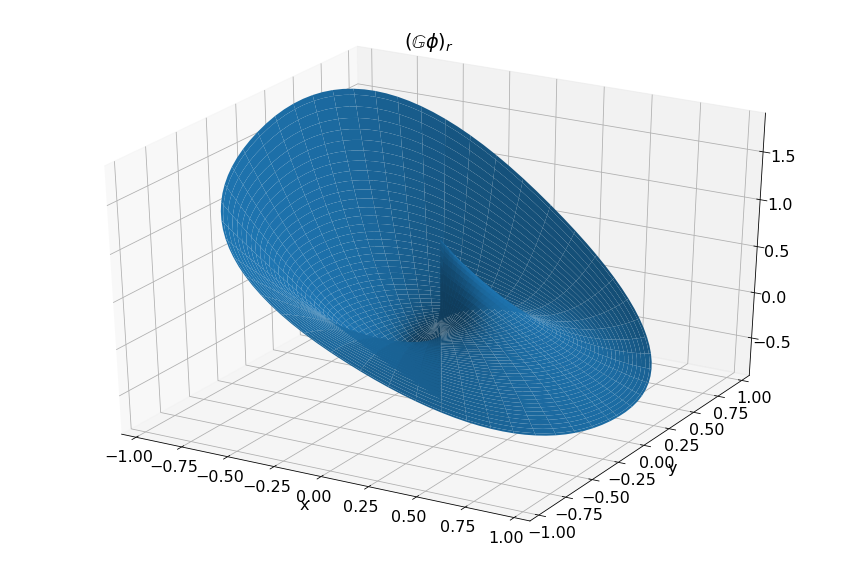

In [112]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, E1)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(r'$(\mathbb{G}\phi)_r$')

Text(0.5,0.92,'$(\\mathbb{G}\\phi)_\\theta$')

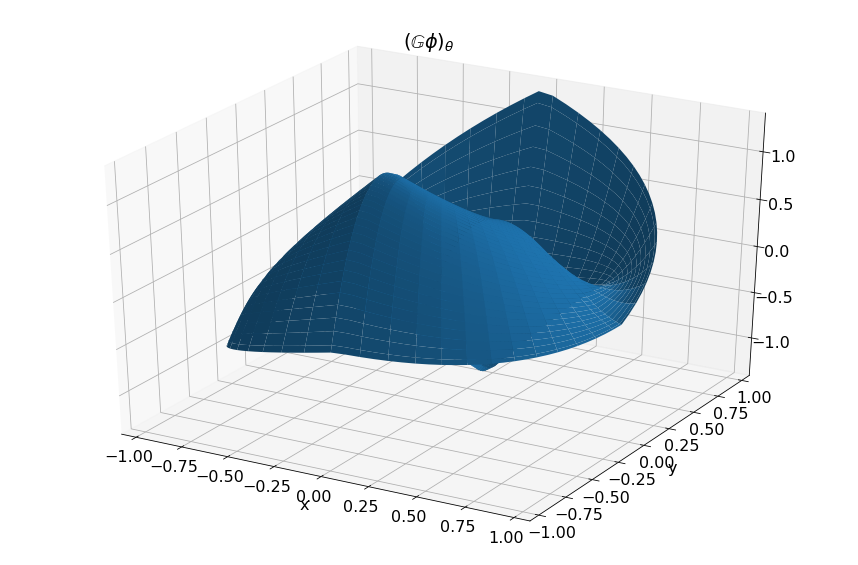

In [113]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, E2)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(r'$(\mathbb{G}\phi)_\theta$')

## 3. 2 Going from $V_1$ to $V_2$ with $\mathbb{C}$

In [115]:
vec1_1 = np.random.rand(3 + Nbase_1*Nel_2 - 2*Nel_2)
vec1_2 = np.random.rand(3 + Nbase_1*Nel_2 - 2*Nel_2)

Text(0.5,0.92,'$\\partial_r E_\\theta-\\partial_\\theta E_r$')

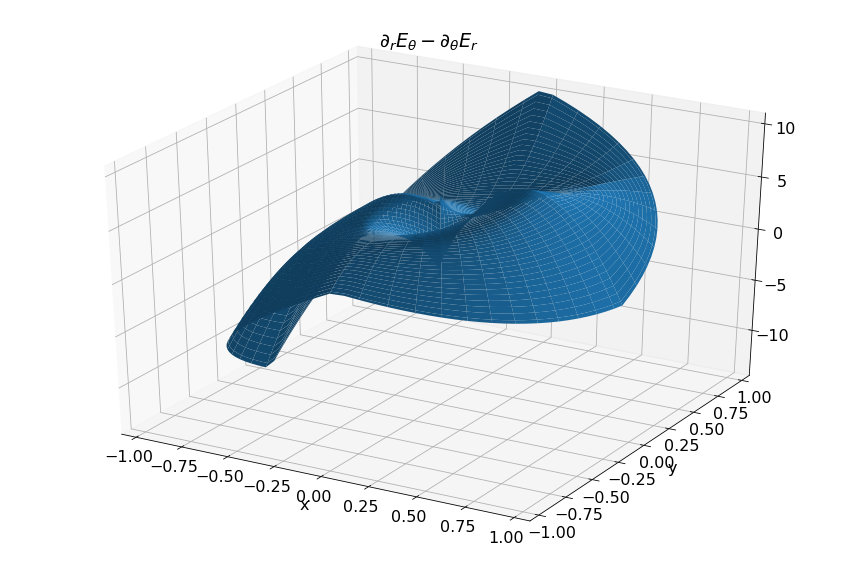

In [116]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


test_vec_a_1 = vec1_1[:3]
test_vec_a_2 = vec1_2[:3]

test_vec_1 = np.reshape(vec1_1[3:], (Nbase_1 - 2, Nel_2))
test_vec_2 = np.reshape(vec1_2[3:], (Nbase_1 - 2, Nel_2))

Q1plot, Q2plot = np.meshgrid(q1plot, q2plot, indexing='ij')

TEST = Lambda1_2(test_vec_a_2, test_vec_2, Q1plot, Q2plot, 1) - Lambda1_1(test_vec_a_1, test_vec_1, Q1plot, Q2plot, 1)
TEST = np.reshape(TEST, (100, 100))

ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, TEST)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(r'$\partial_r E_\theta-\partial_\theta E_r$')

In [117]:
vec2 = CURL.dot(np.concatenate((vec1_1, vec1_2)))

# C1 constraint on coefficients of tensor basis
g0 = vec2[0]*grad_2.dot(gl[0]) + vec2[1]*grad_2.dot(gl[1]) + vec2[2]*grad_2.dot(gl[2])

vec2_full = np.concatenate((g0, vec2[3:]))

In [118]:
B = eva.evaluate_field_V2_2d(vec2_full, [q1plot, q2plot], p, Nbase, T, bc)

B = np.reshape(B, (100, 100))

Text(0.5,0.92,'$\\mathbb{C}E$')

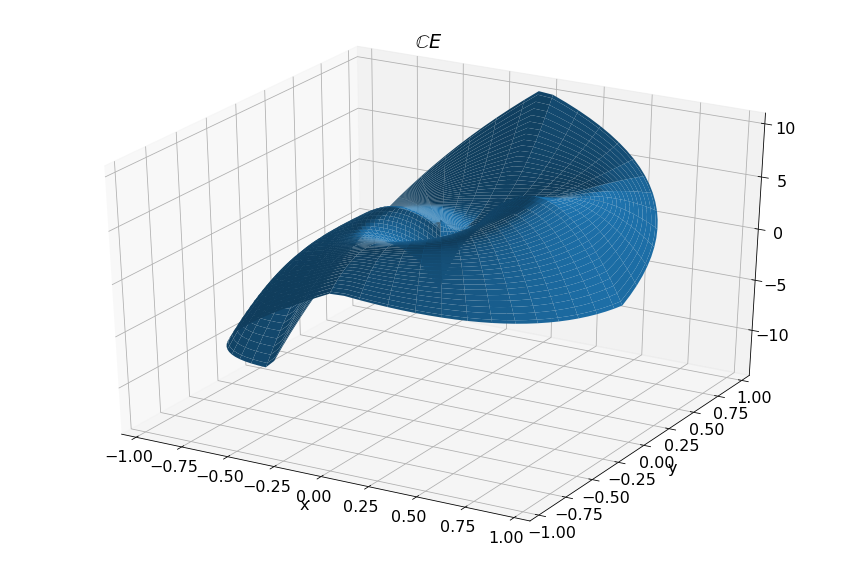

In [119]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

X = spline_map.mapping([cx, cy], [q1plot, q2plot], component='x')
Y = spline_map.mapping([cx, cy], [q1plot, q2plot], component='y')

X = np.reshape(X, (100, 100))
Y = np.reshape(Y, (100, 100))


ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, B)


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title(r'$\mathbb{C}E$')

In [120]:
np.allclose(B, TEST)

False

In [121]:
B

array([[-2.47899541, -2.23504554, -1.99109567, ..., -2.56624943,
        -2.52262242, -2.47899541],
       [-2.10190603, -1.87925492, -1.6566038 , ..., -2.19941651,
        -2.15066127, -2.10190603],
       [-1.73229861, -1.53046041, -1.32862221, ..., -1.83977806,
        -1.78603834, -1.73229861],
       ...,
       [-0.73737158, -0.29731556,  0.14274046, ..., -0.48089786,
        -0.60913472, -0.73737158],
       [-1.08603317, -0.62014912, -0.15426507, ..., -0.81192831,
        -0.94898074, -1.08603317],
       [-1.44217672, -0.9499788 , -0.45778088, ..., -1.15015322,
        -1.29616497, -1.44217672]])

In [122]:
TEST

array([[-0.3281548 , -0.08420493,  0.15974494, ..., -0.41540882,
        -0.37178181, -0.3281548 ],
       [ 0.00570271,  0.22835382,  0.45100494, ..., -0.09180778,
        -0.04305253,  0.00570271],
       [ 0.33251715,  0.53435535,  0.73619355, ...,  0.2250377 ,
         0.27877743,  0.33251715],
       ...,
       [-0.73649378, -0.29643776,  0.14361827, ..., -0.48002006,
        -0.60825692, -0.73649378],
       [-1.08581372, -0.61992967, -0.15404562, ..., -0.81170885,
        -0.94876129, -1.08581372],
       [-1.44217672, -0.9499788 , -0.45778088, ..., -1.15015322,
        -1.29616497, -1.44217672]])